# 투빅스 15기 정규세션 10주차 DCGAN 구현 과제
"빈칸" 부분을 채우는 과제입니다. "빈칸"뿐만 아니라 중간중간 주석 또는 마크다운으로 설명 부탁드립니다  
https://github.com/pytorch/tutorials/blob/master/beginner_source/dcgan_faces_tutorial.py  
위의 주소는 pytorch dcgan 공식 튜토리얼 코드로 해당 코드를 바탕으로 과제를 만들었습니다. 튜토리얼 코드와 과제 코드가 상당부분 유사하므로 어려운 점이 있을 때 참고하면 좋을 것 같습니다  
다만, 그대로 복붙이 아닌 코드를 이해해 나가면서 과제를 수행해주시기 바랍니다  
마지막 과제인 만큼 다들 화이팅!

## 드라이브 연결

In [17]:
# gdrive에 mount
from google.colab import drive
drive.mount('/content/gdrive')
# 경로 설정
import os
os.chdir('/content/gdrive/My Drive/')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## 패키지 임포트

In [18]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms

## MNIST 데이터 불러오기
기존의 MNIST 손글씨 데이터의 경우 1x28x28 이미지 -> dcgan 모델 적용을 위해 1x64x64 이미지로 크기 조절 (물론 28x28이미지도 사용가능하지만 네트워크 구조 수정 필요)  
처음 데이터를 사용할때는 download=True로 데이터를 다운 받기  
이후에 사용할때는 데이터가 이미 다운되있으므로 download=False로 바꿔서 사용

In [19]:
# MNIST dataset
dataroot = './mnist_data/'
imageSize = 64 # the height / width of the input image to network

dataset = dset.MNIST(root = dataroot, download= False,
                     transform = transforms.Compose([
                                                     transforms.Resize(imageSize), #이미지 64x64로 크기 변환
                                                     transforms.ToTensor(), #텐서자료형으로 변환
                                                     transforms.Normalize((0.5,), (0.5,)), #노말라이즈를 통해 -1.~1.의 값을 갖게 변환
                     ]))

### 데이터 확인하기

In [20]:
print('number of training data: ', len(dataset)) #데이터 수 확인
image,_ = dataset[0]

print('Image')
print('========================================')
print('shape of this image\t:', image.shape) #데이터 차원(모양)확인하기

number of training data:  60000
Image
shape of this image	: torch.Size([1, 64, 64])


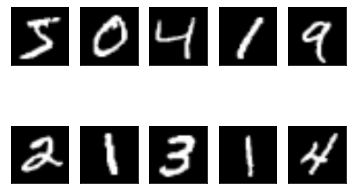

In [21]:
# 학습 데이터 시각화
fig = plt.figure()

for i in range(10):
    image,_ = dataset[i]
    image = (image+1)/2
    image = image.squeeze()
    np_img = image.numpy()
    
    subplot = fig.add_subplot(2, 5, i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(np_img, cmap = 'gray')

plt.show()

### 데이터 로더 정의

In [22]:
# dataloader
batch_size = 256
workers = 2

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle = True, num_workers = workers)

## device 정의

In [23]:
# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 신경망 

In [24]:
#네트워크 하이퍼파라미터 설정
nc = 1 # number of channels in the training images
nz = 100 # size of z latent vector
ngf = 64 # size of feature maps in generator
ndf = 64 # size of feature maps in discriminator


### 신경망 가중치 초기화 함수 정의
신경망의 가중치 초기화 방법에 대해 논문에 자세히 나와있습니다.  
다음 사이트는 파이토치에서 가중치 초기화에 관련된 글 입니다  
https://www.javaer101.com/ko/article/1010427.html

In [25]:
# 논문에 따라 가중치들을 N(0, 0.02^2)으로 초기화한다.
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### 생성자 클래스

trasposed convolution 관련 자료: https://yonghyuc.wordpress.com/2019/08/08/transposed-convolutions-aka-deconvolution/

In [26]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(in_channels=nz, out_channels=ngf * 8, kernel_size=4, stride=1, padding=0, bias=False),   # stride를 통해 pooling을 대체한다.
            nn.BatchNorm2d(ngf * 8),    # 레이어마다 batchnorm을 사용하여 학습의 안정성을 높인다. generator의 마지막 레이어 제외
            nn.ReLU(True),              # 마지막 레이어를 제외하고는 activation함수는 ReLU를 사용한다.
            # state size. (ngf*8) x 4 x 4
            
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()           # 마지막 레이어의 activation함수는 tanh를 사용한다.
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [27]:
netG = Generator().to(device) # 생성자 객체 생성
netG.apply(weights_init) # 위의 정의한 함수로 가중치 초기화

# 생성자 출력
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


### 판별자 클래스

In [28]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # (nc) x 64 x 64)
            nn.Conv2d(nc, ndf, 4,2,1,bias=False),   
            nn.LeakyReLU(0.2, inplace=True),    # activation function은 leakyReLU를 사용한다.

            # ndf x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),        # batchnorm을 사용하여 학습의 안정성을 높인다. discriminator의 첫번째 레이어 제외
            nn.LeakyReLU(0.2, inplace=True),

            # (ndf * 2) x 16 x 16
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # (ndf * 4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()        # 해당 사진이 진짜인지 가짜인지를 구분ㄴ한ㄴ다.
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)

In [29]:
netD = Discriminator().to(device) # 생성자 객체 생성
netD.apply(weights_init) # 위의 정의한 함수로 가중치 초기화

# 판별자 출력
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


## Loss Function & Optimizer

In [30]:
# 손실함수
criterion = nn.BCELoss()

real_label = 1.
fake_label = 0.

# optimizer hyperparameters
learning_rate = 0.0001
beta1 = 0.5

# optimizers
# Adam을 사용하고 모멘텀항을 추가한다.
optimizerD = optim.Adam(netD.parameters(), lr = learning_rate, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr = learning_rate, betas=(beta1, 0.999))

## Train
"빈칸"을 채우고, 각각의 변수 및 메소드가 무엇을 나태는지 혹은 어떻게 계산되는지를 주석으로 설명 부탁드립니다.  
참고하면 좋은 사이트: https://redstarhong.tistory.com/64

In [31]:
import torchvision.utils as vutils
num_epochs = 100
img_list = []
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):

        netD.zero_grad() # Discriminator의 gradient를 초기화한다.
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device) # 진짜 이미지에 대해 라벨을 붙인다.
        output = netD(real_cpu).view(-1)    # 진짜 이미지에 대해 discriminator로 나온 결과
        errD_real = criterion(output, label)    # loss를 계산한다.
        errD_real.backward()                # gradient를 계산한다.
        D_x = output.mean().item()          

        noise = torch.randn(b_size, nz, 1, 1, device=device)    # 랜덤한 노이즈를 만든다.
        fake = netG(noise)              # generator를 통해 fake image를 생성한다.
        label.fill_(fake_label)             # fake label을 만든다.
        output = netD(fake.detach()).view(-1)   # discriminator로 fake image를 분류한다.
        errD_fake = criterion(output, label)    # loss를 계산한다.
        errD_fake.backward()            # gradient를 계산하다.
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake    # discriminator의 Loss는 fake image에 대한 loss와 real image에 대한 loss를 더한 값이다.
        optimizerD.step()               # discriminator를 업데이트한다.


        netG.zero_grad() # generator의 기울기 초기화
        label.fill_(real_label)         # generator의 입장에서는 discriminator가 자시이 만든 사진을 진짜라고 분류해야 하므로 real label을 붙인다. 
        output = netD(fake).view(-1)    # fake image를 discriminator로 분류한다.
        errG = criterion(output, label)     # loss를 계산한다.
        errG.backward()                 # gradient를 계산한다.
        D_G_z2 = output.mean().item()

        optimizerG.step()   # generator를 업데이트한다.

        # 학습 경과 출력
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
            % (epoch, num_epochs, i, len(dataloader),
                errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        if (i % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()     # 후에 시각화를 위해 fake image를 저장하였다.
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

[0/100][0/235]	Loss_D: 1.9916	Loss_G: 2.0691	D(x): 0.5020	D(G(z)): 0.6219 / 0.1763
[0/100][50/235]	Loss_D: 0.0255	Loss_G: 7.6386	D(x): 0.9892	D(G(z)): 0.0139 / 0.0006
[0/100][100/235]	Loss_D: 0.0150	Loss_G: 7.8305	D(x): 0.9942	D(G(z)): 0.0074 / 0.0005
[0/100][150/235]	Loss_D: 0.0040	Loss_G: 7.7592	D(x): 0.9990	D(G(z)): 0.0030 / 0.0005
[0/100][200/235]	Loss_D: 0.0033	Loss_G: 8.0820	D(x): 0.9989	D(G(z)): 0.0021 / 0.0004
[1/100][0/235]	Loss_D: 0.0034	Loss_G: 8.2815	D(x): 0.9996	D(G(z)): 0.0030 / 0.0003
[1/100][50/235]	Loss_D: 0.0019	Loss_G: 8.0961	D(x): 0.9998	D(G(z)): 0.0017 / 0.0003
[1/100][100/235]	Loss_D: 0.0011	Loss_G: 8.0480	D(x): 0.9998	D(G(z)): 0.0009 / 0.0004
[1/100][150/235]	Loss_D: 0.0017	Loss_G: 7.7829	D(x): 0.9998	D(G(z)): 0.0015 / 0.0005
[1/100][200/235]	Loss_D: 0.0011	Loss_G: 7.9740	D(x): 0.9997	D(G(z)): 0.0008 / 0.0004
[2/100][0/235]	Loss_D: 0.0009	Loss_G: 8.0896	D(x): 0.9998	D(G(z)): 0.0007 / 0.0003
[2/100][50/235]	Loss_D: 0.0006	Loss_G: 8.3319	D(x): 0.9999	D(G(z)): 0.000

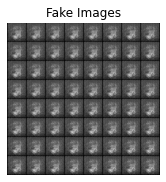

In [32]:
# # Grab a batch of real images from the dataloader
# real_batch = next(iter(dataloader))

# # Plot the real images
# plt.figure(figsize=(15,15))
# plt.subplot(1,2,1)
# plt.axis("off")
# plt.title("Real Images")
# plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()